# Ejercicio práctico sobre series temporales
A partir de los valores diarios de temperatura desde 1981 hasta 1990 prepara dos modelos de series temporales distintos:
1. Modelo single step, donde a partir de la temperatura de los últimos siete días somos capaces de estimar la temperatura del día siguiente.
2. Modelo multi step, donde a partir de la temperatura de los últimos 28 días, estimamos la temperatura de los siete siguientes. 

Para el primer ejercicio utiliza redes neuronales dense y para el segundo utiliza RNN LSTM.
Acuérdate de analizar previamente la serie temporal, para ver si hay valores anómalos, estandarizar los datos, dividirlos en los conjuntos de entrenamiento y posteriormente, visualizar las estimaciones de los modelos en cada uno de los ejercicios.

Puedes crear atributos adicionales relacionados con la componente temporal de los datos utilizando las transformaciones de seno y coseno que hemos visto en clase.

In [58]:
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython
import IPython.display

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [59]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [60]:
date_time = pd.to_datetime(df["Date"], format='%Y-%m-%d')
df.pop("Date")

0       1981-01-01
1       1981-01-02
2       1981-01-03
3       1981-01-04
4       1981-01-05
           ...    
3645    1990-12-27
3646    1990-12-28
3647    1990-12-29
3648    1990-12-30
3649    1990-12-31
Name: Date, Length: 3650, dtype: object

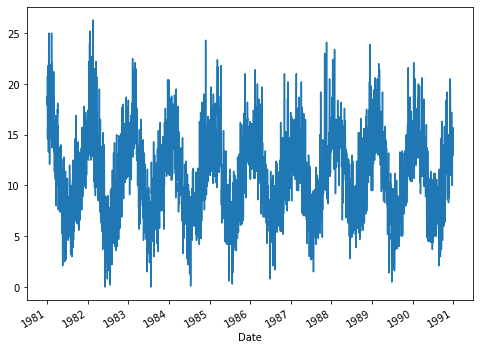

In [61]:
plot_features = df["Temp"]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [62]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp,3650.0,11.177753,4.071837,0.0,8.3,11.0,14.0,26.3


###División del conjunto de datos

In [63]:
column_index = {columns: index for index, columns in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

###Normalizacion de los datos

In [64]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### WindowGenerator

In [65]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df


    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_index = {columns: index for index, columns in
                                    enumerate(label_columns)}
    self.column_index = {columns: index for index, columns in
                           enumerate(train_df.columns)}

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_index = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_index = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Tamaño total de la ventana: {self.total_window_size}',
        f'Índices de entrada: {self.input_index}',
        f'Índices de salida: {self.label_index}',
        f'Columnas de salida: {self.label_columns}'])

In [66]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_index[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [67]:
def plot(self, model=None, plot_col='Temp', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_index[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_index, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_index.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
      
    plt.scatter(self.label_index, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_index, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [68]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [69]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [70]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  history = model.fit(window.train, epochs=5, validation_data = window.val,
                      callbacks=[early_stopping])
  return history
  

###Dense

In [71]:
single_step_window = WindowGenerator(
    input_width=7, label_width=1, shift=1,
    label_columns =['Temp']
)
single_step_window

Tamaño total de la ventana: 8
Índices de entrada: [0 1 2 3 4 5 6]
Índices de salida: [7]
Columnas de salida: ['Temp']

In [72]:
dense = tf.keras.Sequential([
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units=64, activation='relu'),
                             tf.keras.layers.Dense(units=64, activation='relu'),
                             tf.keras.layers.Dense(units=1),
                              tf.keras.layers.Reshape([1, -1]),
])

val_performance = {}
performance = {}
history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

Epoch 1/5
80/80 [==============================] - 1s 8ms/step - loss: 0.4560 - mean_absolute_error: 0.5286 - val_loss: 0.3363 - val_mean_absolute_error: 0.4584
Epoch 2/5
80/80 [==============================] - 1s 6ms/step - loss: 0.3736 - mean_absolute_error: 0.4778 - val_loss: 0.3261 - val_mean_absolute_error: 0.4528
Epoch 3/5
80/80 [==============================] - 1s 6ms/step - loss: 0.3671 - mean_absolute_error: 0.4735 - val_loss: 0.3377 - val_mean_absolute_error: 0.4597
Epoch 4/5
80/80 [==============================] - 1s 6ms/step - loss: 0.3627 - mean_absolute_error: 0.4700 - val_loss: 0.3245 - val_mean_absolute_error: 0.4515
Epoch 5/5
12/12 [==============================] - 0s 2ms/step - loss: 0.3260 - mean_absolute_error: 0.4456


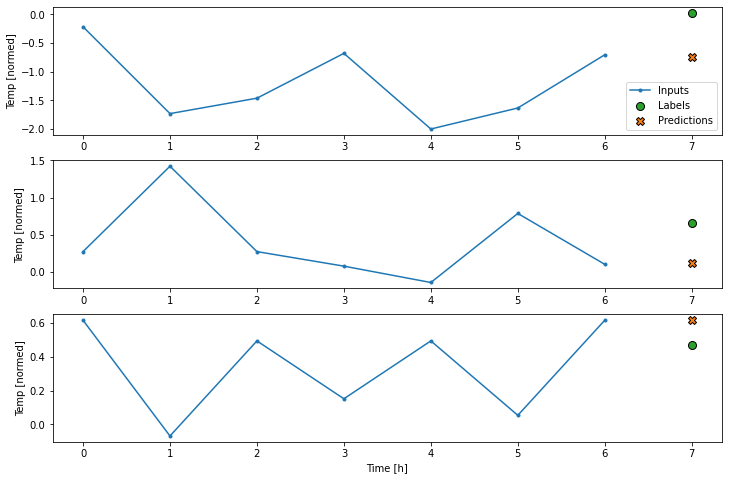

In [73]:
single_step_window.plot(dense)

###LSTM

In [74]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=28,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)
multi_window

Tamaño total de la ventana: 35
Índices de entrada: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Índices de salida: [28 29 30 31 32 33 34]
Columnas de salida: None

In [75]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

22/22 [==============================] - 0s 6ms/step - loss: 0.4265 - mean_absolute_error: 0.5086


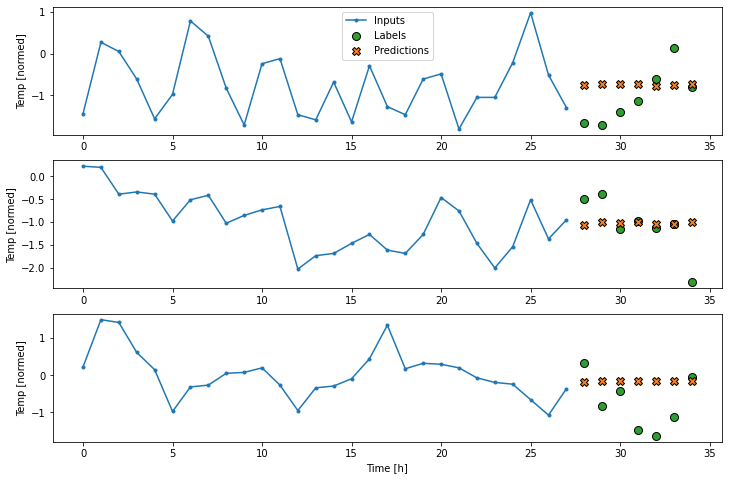

In [76]:
multi_window.plot(multi_lstm_model)

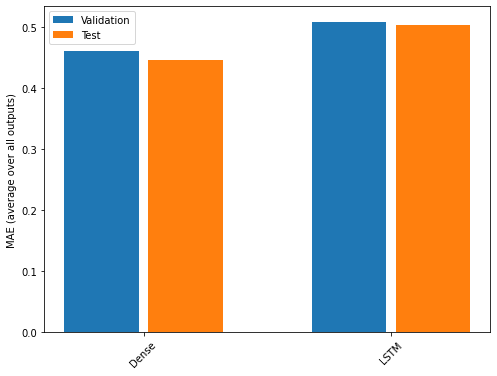

In [77]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()